In [1]:
import os
import sys
import importlib
import pickle
import emcee
import corner
AbsPath = str(os.path.abspath(""))+"/.."
sys.path.append(AbsPath)
#from Scripts.Plots import SDSS_Plots
import scipy.stats
from itertools import cycle
#Add_SDSS = SDSS_Plots.SDSS_Plots(11.5,15,0.1)
import matplotlib.pyplot as plt
from Functions import Functions as F
HMF_fun = F.Make_HMF_Interp()
from Functions.Functions import Make_HMF_Interp
import numpy as np
import matplotlib.pyplot as plt
import colossus.halo.mass_adv as massdefs
from colossus.halo.mass_so import M_to_R
from halotools import empirical_models
from colossus.cosmology import cosmology
cosmology.setCosmology("planck15")
from astropy.cosmology import Planck15 as Cosmo_AstroPy
Cosmo =cosmology.getCurrent()


h = Cosmo.h

#Abundance Matching Parameters
Override =\
{\
'M10':12.0,\
'SHMnorm10':0.032,\
'beta10':1.5,\
'gamma10':0.56,\
'M11':0.6,\
'SHMnorm11':-0.014,\
'beta11':-2,\
'gamma11':0.08\
}


AbnMtch =\
{\
'Behroozi13': False,\
'Behroozi18': False,\
'B18c':False,\
'B18t':False,\
'G18':False,\
'G18_notSE':False,\
'G19_SE':False,\
'G19_cMod':False,\
'Lorenzo18':False,\
'Moster': False,\
'Moster10': False,\
'Illustris': False,\
'z_Evo':True,\
'Scatter': 0.15,\
'Override_0': False,\
'Override_z': False,\
'Override': Override,\
'PFT': False,\
'M_PFT1': False,\
'M_PFT2': False,\
'M_PFT3': False,\
'N_PFT1': False,\
'N_PFT2': False,\
'N_PFT3': False,\
'b_PFT1': False,\
'b_PFT2': False,\
'b_PFT3': False,\
'g_PFT1': False,\
'g_PFT2': False,\
'g_PFT3': False,\
'g_PFT4': False\
}

Paramaters = \
{\
'AbnMtch' : AbnMtch,\
'AltDynamicalTime': 1,\
'NormRnd': 0.5,\
'SFR_Model': 'CE',\
'PreProcessing': False,\
'AltDynamicalTimeB': False\
}



#Subhalomass function parameters macc/M0
Unevolved = {\
'gamma' : 0.22,\
'alpha' : -0.91,\
'beta' : 6,\
'omega' : 3,\
'a' : 1,\
}

In [ ]:
importlib.reload(F)

11.45 0.4968


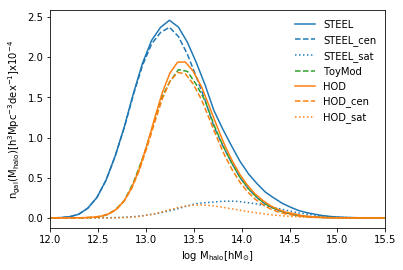

In [153]:
#Load Tinker_HOD
Tkr_hod = np.loadtxt(AbsPath+"/Data/Observational/Tinker_HOD/pdf_censat_hod.dat", skiprows=2).T
Tkr_RX2 = np.loadtxt(AbsPath+"/Data/Observational/Tinker_HOD/pdf_censat_RX2.dat", skiprows=2).T
#Load STEEL
Fit = ('1.0', True, True, True, 'G19_DPL', 'G19_SE')#('1.0', False, False, True, 'G19_DPL', 'G19_SE')
AvaHaloMass, z, AnalyticalModelFrac_highz, AnalyticalModelNoFrac_highz, SM_Cuts = F.LoadData_Sat_Env_Highz(Fit)
AvaHaloMassBins = AvaHaloMass[:,1:] - AvaHaloMass[:,:-1] 
AvaHaloMassBins = np.concatenate((AvaHaloMassBins, np.array([AvaHaloMassBins[:,-1]]).T), axis = 1)



#Plot Full STEEL
Data_M_ix = np.digitize(11.45, bins = SM_Cuts)-1
Data_z_ix = np.digitize(0.5, bins = z)-1
print(SM_Cuts[Data_M_ix],z[Data_z_ix])
Y_Model = np.divide(AnalyticalModelNoFrac_highz[Data_M_ix][Data_z_ix], AvaHaloMassBins[Data_z_ix])
X_sat, Y_sat = F.Gauss_Scatt(AvaHaloMass[Data_z_ix], Y_Model, Scatt = 0.1)
Y_sat = Y_sat*(10**4)*(h**-3)

AbnMtch[Fit[5]] = True
Central_Wt = HMF_fun(AvaHaloMass[Data_z_ix], 0.5)
SM = F.DarkMatterToStellarMass(AvaHaloMass[Data_z_ix]-np.log10(h), 0.5, Paramaters, ScatterOn=False)
Norm = scipy.stats.norm(SM, 0.15)
Prob = 1-Norm.cdf(11.45)
Central_Wt = Central_Wt*Prob
X_cen, Y_cen = F.Gauss_Scatt(AvaHaloMass[Data_z_ix], Central_Wt, Scatt = 0.1)
Y_cen = Y_cen*(10**4)
AbnMtch[Fit[5]] = False

#X_sat==X_cen
plt.plot(X_sat, Y_cen+Y_sat, "-",label ="STEEL", color = "C0")
plt.plot(X_cen, Y_cen, "--",label ="STEEL_cen", color = "C0")
plt.plot(X_sat, Y_sat, ":",label = "STEEL_sat", color = "C0")



#Central only toy model
Override['M10'] = 12.0
Override['SHMnorm10'] = 0.032
Override['beta10'] = 1.5
Override['gamma10'] = 0.58
Override['M11'] = 0.6
Override['SHMnorm11'] = -0.014
Override['beta11'] = -0.7
Override['gamma11'] = 0.08

AbnMtch['Override_z'] = True
Central_Wt = HMF_fun(AvaHaloMass[Data_z_ix], 0.5)
SM = F.DarkMatterToStellarMass(AvaHaloMass[Data_z_ix]-np.log10(h), 0.5, Paramaters, ScatterOn = False)
Norm = scipy.stats.norm(SM, 0.1)
Prob = 1-Norm.cdf(11.45)
Central_Wt = Central_Wt*Prob
X_cen, Y_cen = F.Gauss_Scatt(AvaHaloMass[Data_z_ix], Central_Wt, Scatt = 0.1)
Y_cen = Y_cen*(10**4)
AbnMtch['Override_z'] = False

plt.plot(X_cen, Y_cen, "--",label ="ToyMod", color = "C2")


#"""
plt.plot(Tkr_hod[0], Tkr_hod[1]+(Tkr_hod[2]/10), "-",label = "HOD", color = "C1")
plt.plot(Tkr_hod[0], Tkr_hod[1], "--",label = "HOD_cen", color = "C1")
plt.plot(Tkr_hod[0], Tkr_hod[2]/10, ":",label = "HOD_sat", color = "C1")
#"""
"""
plt.plot(Tkr_RX2[0], Tkr_RX2[1]+(Tkr_RX2[2]/10), "-",label = "HOD", color = "C2")
plt.plot(Tkr_RX2[0], Tkr_RX2[1], "--",label = "HOD_cen", color = "C2")
plt.plot(Tkr_RX2[0], (Tkr_RX2[2]/10), ":",label = "HOD_sat", color = "C2")
"""

plt.xlim(12, 15.5)
plt.xlabel("log $\mathrm{M_{halo} [hM_{\odot}]}$")
plt.ylabel("$\mathrm{n_{gal}(M_{halo}) [h^3Mpc^{-3}dex^{-1}]x10^{-4}}$")
plt.legend(frameon = False)
plt.show()



11.45 0.4968
11.45 0.4968
11.45 0.4968
11.45 0.4968
11.45 0.4968


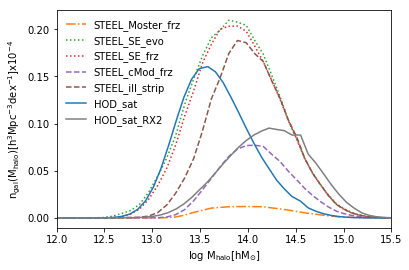

In [176]:


#Load Tinker_HOD
Tkr_hod = np.loadtxt(AbsPath+"/Data/Observational/Tinker_HOD/pdf_censat_hod.dat", skiprows=2).T
Tkr_RX2 = np.loadtxt(AbsPath+"/Data/Observational/Tinker_HOD/pdf_censat_RX2.dat", skiprows=2).T


#Load STEEL
Fit = ('1.0', False, False, True, 'G19_DPL', 'Moster')
AvaHaloMass, z, AnalyticalModelFrac_highz, AnalyticalModelNoFrac_highz, SM_Cuts = F.LoadData_Sat_Env_Highz(Fit)
AvaHaloMassBins = AvaHaloMass[:,1:] - AvaHaloMass[:,:-1] 
AvaHaloMassBins = np.concatenate((AvaHaloMassBins, np.array([AvaHaloMassBins[:,-1]]).T), axis = 1)

#Plot STEEL sat
Data_M_ix = np.digitize(11.45, bins = SM_Cuts)-1
Data_z_ix = np.digitize(0.5, bins = z)-1
print(SM_Cuts[Data_M_ix],z[Data_z_ix])
Y_Model = np.divide(AnalyticalModelNoFrac_highz[Data_M_ix][Data_z_ix], AvaHaloMassBins[Data_z_ix])
X_sat, Y_sat = F.Gauss_Scatt(AvaHaloMass[Data_z_ix], Y_Model, Scatt = 0.1)
Y_sat = Y_sat*(10**4)*(h**-3)

plt.plot(X_sat, Y_sat, "-.",label = "STEEL_Moster_frz", color = "C1")

Output = np.vstack((X_sat, Y_sat))


#Load STEEL
Fit = ('1.0', True, True, True, 'G19_DPL', 'G19_SE')#('1.0', False, False, True, 'G19_DPL', 'G19_SE')
AvaHaloMass, z, AnalyticalModelFrac_highz, AnalyticalModelNoFrac_highz, SM_Cuts = F.LoadData_Sat_Env_Highz(Fit)
AvaHaloMassBins = AvaHaloMass[:,1:] - AvaHaloMass[:,:-1] 
AvaHaloMassBins = np.concatenate((AvaHaloMassBins, np.array([AvaHaloMassBins[:,-1]]).T), axis = 1)

#Plot STEEL sat
Data_M_ix = np.digitize(11.45, bins = SM_Cuts)-1
Data_z_ix = np.digitize(0.5, bins = z)-1
print(SM_Cuts[Data_M_ix],z[Data_z_ix])
Y_Model = np.divide(AnalyticalModelNoFrac_highz[Data_M_ix][Data_z_ix], AvaHaloMassBins[Data_z_ix])
X_sat, Y_sat = F.Gauss_Scatt(AvaHaloMass[Data_z_ix], Y_Model, Scatt = 0.1)
Y_sat = Y_sat*(10**4)*(h**-3)

plt.plot(X_sat, Y_sat, ":",label = "STEEL_SE_evo", color = "C2")

Output = np.vstack((Output, Y_sat))

#Load STEEL
Fit = ('1.0', False, False, True, 'G19_DPL', 'G19_SE')#('1.0', False, False, True, 'G19_DPL', 'G19_SE')
AvaHaloMass, z, AnalyticalModelFrac_highz, AnalyticalModelNoFrac_highz, SM_Cuts = F.LoadData_Sat_Env_Highz(Fit)
AvaHaloMassBins = AvaHaloMass[:,1:] - AvaHaloMass[:,:-1] 
AvaHaloMassBins = np.concatenate((AvaHaloMassBins, np.array([AvaHaloMassBins[:,-1]]).T), axis = 1)

#Plot STEEL sat
Data_M_ix = np.digitize(11.45, bins = SM_Cuts)-1
Data_z_ix = np.digitize(0.5, bins = z)-1
print(SM_Cuts[Data_M_ix],z[Data_z_ix])
Y_Model = np.divide(AnalyticalModelNoFrac_highz[Data_M_ix][Data_z_ix], AvaHaloMassBins[Data_z_ix])
X_sat, Y_sat = F.Gauss_Scatt(AvaHaloMass[Data_z_ix], Y_Model, Scatt = 0.1)
Y_sat = Y_sat*(10**4)*(h**-3)

plt.plot(X_sat, Y_sat, ":",label = "STEEL_SE_frz", color = "C3")

Output = np.vstack((Output, Y_sat))

#Load STEEL
Fit = ('1.0', False, False, True, 'G19_DPL', 'G19_cMod')#('1.0', False, False, True, 'G19_DPL', 'G19_SE')
AvaHaloMass, z, AnalyticalModelFrac_highz, AnalyticalModelNoFrac_highz, SM_Cuts = F.LoadData_Sat_Env_Highz(Fit)
AvaHaloMassBins = AvaHaloMass[:,1:] - AvaHaloMass[:,:-1] 
AvaHaloMassBins = np.concatenate((AvaHaloMassBins, np.array([AvaHaloMassBins[:,-1]]).T), axis = 1)

#Plot STEEL sat
Data_M_ix = np.digitize(11.45, bins = SM_Cuts)-1
Data_z_ix = np.digitize(0.5, bins = z)-1
print(SM_Cuts[Data_M_ix],z[Data_z_ix])
Y_Model = np.divide(AnalyticalModelNoFrac_highz[Data_M_ix][Data_z_ix], AvaHaloMassBins[Data_z_ix])
X_sat, Y_sat = F.Gauss_Scatt(AvaHaloMass[Data_z_ix], Y_Model, Scatt = 0.1)
Y_sat = Y_sat*(10**4)*(h**-3)

plt.plot(X_sat, Y_sat, "--",label = "STEEL_cMod_frz", color = "C4")

Output = np.vstack((Output, Y_sat))

#Load STEEL
Fit = ('1.0', True, False, True, 'Illustris', 'Illustris')
AvaHaloMass, z, AnalyticalModelFrac_highz, AnalyticalModelNoFrac_highz, SM_Cuts = F.LoadData_Sat_Env_Highz(Fit)
AvaHaloMassBins = AvaHaloMass[:,1:] - AvaHaloMass[:,:-1] 
AvaHaloMassBins = np.concatenate((AvaHaloMassBins, np.array([AvaHaloMassBins[:,-1]]).T), axis = 1)

#Plot STEEL sat
Data_M_ix = np.digitize(11.45, bins = SM_Cuts)-1
Data_z_ix = np.digitize(0.5, bins = z)-1
print(SM_Cuts[Data_M_ix],z[Data_z_ix])
Y_Model = np.divide(AnalyticalModelNoFrac_highz[Data_M_ix][Data_z_ix], AvaHaloMassBins[Data_z_ix])
X_sat, Y_sat = F.Gauss_Scatt(AvaHaloMass[Data_z_ix], Y_Model, Scatt = 0.1)
Y_sat = Y_sat*(10**4)*(h**-3)

plt.plot(X_sat, Y_sat, "--",label = "STEEL_ill_strip", color = "C5")

Output = np.vstack((Output, Y_sat))

#HOD
plt.plot(Tkr_hod[0], Tkr_hod[2]/10, "-",label = "HOD_sat", color = "C0")
plt.plot(Tkr_RX2[0], (Tkr_RX2[2]/10), "-",label = "HOD_sat_RX2", color = "C7")

plt.xlim(12, 15.5)
plt.xlabel("log $\mathrm{M_{halo} [hM_{\odot}]}$")
plt.ylabel("$\mathrm{n_{gal}(M_{halo}) [h^3Mpc^{-3}dex^{-1}]x10^{-4}}$")
plt.legend(frameon = False)
plt.show()

np.savetxt("StewPaper.txt", Output)

In [181]:
Output = np.loadtxt("StewPaper.txt")
M = Output[0]
M13_frz = Output[1]
SE_evo = Output[2]
SE_frz = Output[3]
cmod_frz = Output[4]
Ill_strip = Output[5]

array([10.73723819, 10.83536019, 10.93308019, 11.03090519, 11.12905519,
       11.22697519, 11.32439519, 11.42191519, 11.51928519, 11.61663519,
       11.71380519, 11.81097519, 11.90751519, 12.00413519, 12.10129519,
       12.19807519, 12.29403519, 12.39018519, 12.48602519, 12.58181519,
       12.67731519, 12.77277519, 12.86719519, 12.96170519, 13.05703519,
       13.15176519, 13.24491519, 13.33862519, 13.43216519, 13.52454519,
       13.61692519, 13.70907519, 13.79945519, 13.88994519, 13.98168519,
       14.07240519, 14.16044519, 14.24892519, 14.33622519, 14.42331519,
       14.50917519, 14.59468519, 14.67673519, 14.75867519, 14.84322519,
       14.92534519, 15.00262519, 15.08024519, 15.15587519, 15.23057519,
       15.30317519, 15.37493519, 15.43990519, 15.50473519, 15.57466519,
       15.64008519, 15.69627519])

In [162]:
def ReturnCentralDist(HM_range, theta):
    Gamma, Gamma_z, Scatter = theta
    #Central only toy model
    #Args:
    #    HM_range: [Msun h-1]
    #    Gamma: SMHM high mass slope parameter
    #    Gamma_z: SMHM high mass slope evolution parameter
    #    Scatter: SMHM scatter parameter
    #Returns:
    #    Y_cen: Numberdensity of central galaxies above 10^11 as a fucntion of halo mass [h^3Mpc^{-3}dex^{-1}]x10^{-4}
    """
    Override['M10'] = 12.0
    Override['SHMnorm10'] = 0.032
    Override['beta10'] = 1.5
    Override['gamma10'] = Gamma#0.525
    Override['M11'] = 0.6
    Override['SHMnorm11'] = -0.014
    Override['beta11'] = -0.7
    Override['gamma11'] = Gamma_z#0.08
    """
    Override_lcl =\
    {\
    'M10':12.0,\
    'SHMnorm10':0.032,\
    'beta10':1.5,\
    'gamma10':Gamma,\
    'M11':0.6,\
    'SHMnorm11':-0.014,\
    'beta11':-0.7,\
    'gamma11':Gamma_z\
    }
    
    
    AbnMtch_lcl =\
    {\
    'Behroozi13': False,\
    'Behroozi18': False,\
    'B18c':False,\
    'B18t':False,\
    'G18':False,\
    'G18_notSE':False,\
    'G19_SE':False,\
    'G19_cMod':False,\
    'Lorenzo18':False,\
    'Moster': False,\
    'Moster10': False,\
    'Illustris': False,\
    'z_Evo':True,\
    'Scatter': 0.15,\
    'Override_0': False,\
    'Override_z': False,\
    'Override': Override_lcl,\
    'PFT': False,\
    'M_PFT1': False,\
    'M_PFT2': False,\
    'M_PFT3': False,\
    'N_PFT1': False,\
    'N_PFT2': False,\
    'N_PFT3': False,\
    'b_PFT1': False,\
    'b_PFT2': False,\
    'b_PFT3': False,\
    'g_PFT1': False,\
    'g_PFT2': False,\
    'g_PFT3': False,\
    'g_PFT4': False\
    }

    Paramaters_lcl = \
    {\
    'AbnMtch' : AbnMtch_lcl,\
    'AltDynamicalTime': 1,\
    'NormRnd': 0.5,\
    'SFR_Model': 'CE',\
    'PreProcessing': False,\
    'AltDynamicalTimeB': False\
    }
    
    AbnMtch_lcl['Override_z'] = True
    Central_Wt = HMF_fun(HM_range, 0.5)
    SM = F.DarkMatterToStellarMass(HM_range - np.log10(h), 0.5, Paramaters_lcl, ScatterOn = False)
    Norm = scipy.stats.norm(SM, Scatter)
    Prob = 1-Norm.cdf(11.45)
    Central_Wt = Central_Wt*Prob
    X_cen, Y_cen = F.Gauss_Scatt(HM_range, Central_Wt, Scatt = 0.1)
    Y_cen = Y_cen*(10**4)
    AbnMtch_lcl['Override_z'] = False
    return Y_cen

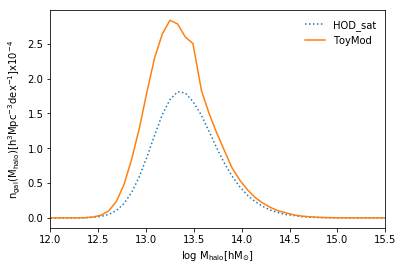

In [163]:
#Load Tinker_HOD
Tkr_hod = np.loadtxt(AbsPath+"/Data/Observational/Tinker_HOD/pdf_censat_hod.dat", skiprows=2).T
Tkr_RX2 = np.loadtxt(AbsPath+"/Data/Observational/Tinker_HOD/pdf_censat_RX2.dat", skiprows=2).T
plt.plot(Tkr_hod[0], Tkr_hod[1], ":",label = "HOD_sat", color = "C0")
theta = 0.55, 0.0, 0.1
Y = ReturnCentralDist(Tkr_hod[0], theta)



plt.plot(Tkr_hod[0], Y, label = "ToyMod", color = "C1")
plt.legend(frameon = False)
plt.xlim(12, 15.5)
plt.xlabel("log $\mathrm{M_{halo} [hM_{\odot}]}$")
plt.ylabel("$\mathrm{n_{gal}(M_{halo}) [h^3Mpc^{-3}dex^{-1}]x10^{-4}}$")
plt.show()

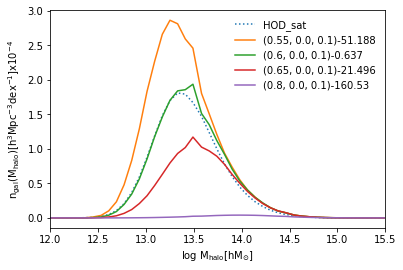

In [175]:
gt12 = np.digitize(12, bins = Tkr_hod[0])-1
theta = 0.55, 0.0, 0.1
plt.plot(Tkr_hod[0][gt12:], Tkr_hod[1][gt12:], ":",label = "HOD_sat", color = "C0")


theta = 0.55, 0.0, 0.1
RMS = lnlike(theta, Tkr_hod[0][gt12:], Tkr_hod[1][gt12:])
Y = ReturnCentralDist(Tkr_hod[0][gt12:], theta)
plt.plot(Tkr_hod[0][gt12:], Y, label = str(theta)+str(round(RMS, 3)), color = "C1")


theta = 0.6, 0.0, 0.1
RMS = lnlike(theta, Tkr_hod[0][gt12:], Tkr_hod[1][gt12:])
Y = ReturnCentralDist(Tkr_hod[0][gt12:], theta)
plt.plot(Tkr_hod[0][gt12:], Y, label = str(theta)+str(round(RMS, 3)), color = "C2")


theta = 0.65, 0.0, 0.1
RMS = lnlike(theta, Tkr_hod[0][gt12:], Tkr_hod[1][gt12:])
Y = ReturnCentralDist(Tkr_hod[0][gt12:], theta)
plt.plot(Tkr_hod[0][gt12:], Y, label = str(theta)+str(round(RMS, 3)), color = "C3")


theta = 0.8, 0.0, 0.1
RMS = lnlike(theta, Tkr_hod[0][gt12:], Tkr_hod[1][gt12:])
Y = ReturnCentralDist(Tkr_hod[0][gt12:], theta)
plt.plot(Tkr_hod[0][gt12:], Y, label = str(theta)+str(round(RMS, 3)), color = "C4")

plt.legend(frameon = False)
plt.xlim(12, 15.5)
plt.xlabel("log $\mathrm{M_{halo} [hM_{\odot}]}$")
plt.ylabel("$\mathrm{n_{gal}(M_{halo}) [h^3Mpc^{-3}dex^{-1}]x10^{-4}}$")
plt.show()

In [166]:
#MCMC Functions

#This is the likelyhood function
def lnlike(theta, HM, y):
    g, g_z, s = theta
    model = ReturnCentralDist(HM, theta)
    
    return -0.5*np.power(sum(y-model), 2)
    
    #RMS = 1 - np.divide(np.sqrt(np.sum(np.power(model-y, 2))), len(y))
    #return np.log(RMS)

#This is the log-prior function
def lnprior(theta):
    g, g_z, s = theta
    if (0.55<g<0.57) and (-0.2<g_z<0.2) and (0.01<s<0.2):
        return 0.0
    else:
        return -np.inf
def lnprob(theta, x, y):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y)

In [167]:
#set up initial conditions
ndim, nwalkers = 3, 100
pos = [[0.55,0.0, 0.1] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [168]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(Tkr_hod[0][gt12:], Tkr_hod[1][gt12:]), threads = 20)

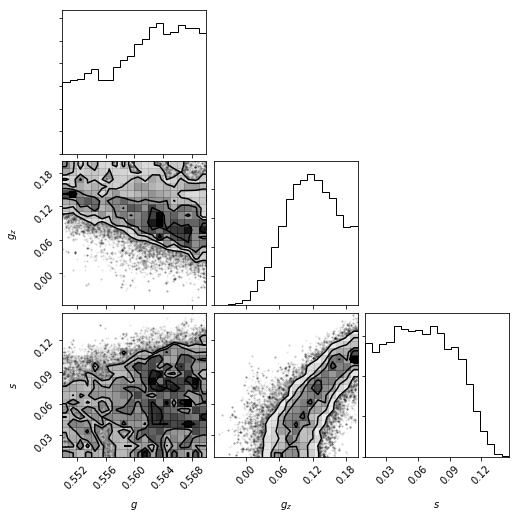

In [169]:
sampler.run_mcmc(pos, 500)
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["$g$", "$g_z$", "$s$"])
fig.show()
#fig.savefig("triangle.png")

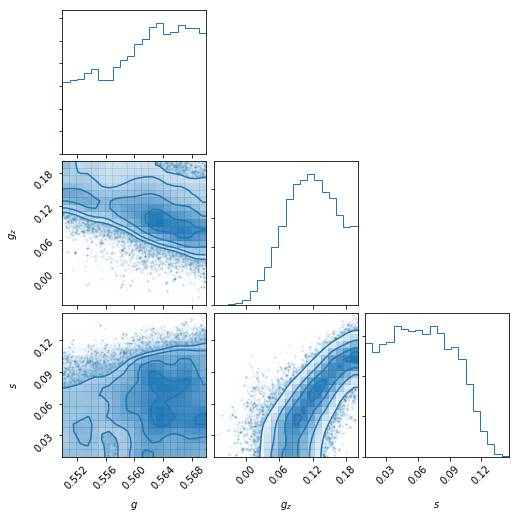

In [170]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["$g$", "$g_z$", "$s$"], color = "C0", smooth = True)
fig.show()

In [171]:
import pickle

(11.905137061320847, 0.39698757865567025, 0.34327156695521666) (0.028566280058904436, 0.01763549526499214, 0.013310494487997305) (2.0888713645625696, 1.2056816181201224, 1.0195716242723512) (0.6377324435229936, 0.11253512697468615, 0.1022696274563385)


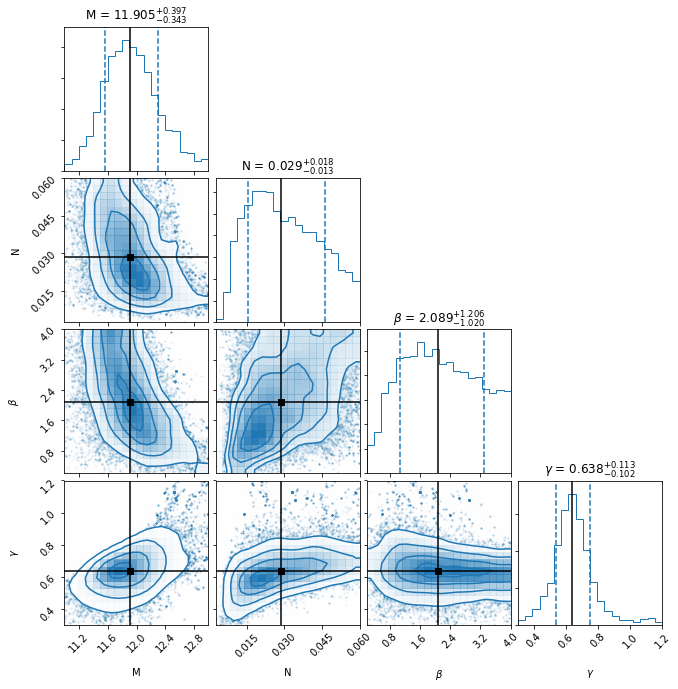

In [172]:
samples =  pickle.load(open(AbsPath+"/Data/Model/Output/Other/SMHM_Fitting/MCMC_Chain_lz.pkl", 'rb'))

M, N, b, g = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),zip(*np.percentile(samples, [16, 50, 84],axis=0)))
print(M, N, b, g)
fig = corner.corner(samples, labels=["M", "N", r"$\beta$", r"$\gamma$"], truths = [M[0], N[0], b[0], g[0]],\
                    color = "C0", truth_color = "k", smooth = True, quantiles=[0.16, 0.84],\
                    show_titles = True, title_fmt= ".3f")
fig.savefig(AbsPath+"/Figures/SMHM_Fit/MCMC_plot_lz.png")
fig.savefig(AbsPath+"/Figures/SMHM_Fit/MCMC_plot_lz.pdf")
fig.show()

(0.5350390499949208, 0.22041159372709884, 0.17938338583950308) (-0.016941792377540163, 0.005730857896192093, 0.003988599825902869) (-1.0359876835697834, 0.5346013519828196, 0.3265006473157075) (-0.0777594287629131, 0.18129626212231753, 0.13200807217927946)


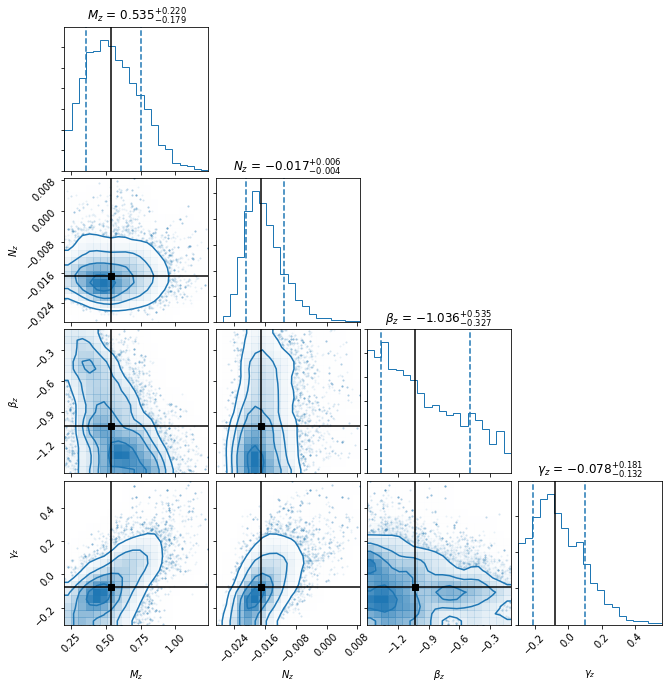

In [173]:
samples =  pickle.load(open(AbsPath+"/Data/Model/Output/Other/SMHM_Fitting/MCMC_Chain_hz.pkl", 'rb'))

M, N, b, g = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),zip(*np.percentile(samples, [16, 50, 84],axis=0)))
print(M, N, b, g)
fig = corner.corner(samples, labels=[r"$M_z$", r"$N_z$", r"$\beta_z$", r"$\gamma_z$"], truths = [M[0], N[0], b[0], g[0]],\
                    color = "C0", truth_color = "k", smooth = True, quantiles=[0.16, 0.84],\
                   show_titles = True, title_fmt= ".3f")
fig.savefig(AbsPath+"/Figures/SMHM_Fit/MCMC_plot_hz.png")
fig.savefig(AbsPath+"/Figures/SMHM_Fit/MCMC_plot_hz.pdf")
fig.show()

In [184]:
np.vstack?

Signature: np.vstack(tup)
Docstring:
Stack arrays in sequence vertically (row wise).

This is equivalent to concatenation along the first axis after 1-D arrays
of shape `(N,)` have been reshaped to `(1,N)`. Rebuilds arrays divided by
`vsplit`.

This function makes most sense for arrays with up to 3 dimensions. For
instance, for pixel-data with a height (first axis), width (second axis),
and r/g/b channels (third axis). The functions `concatenate`, `stack` and
`block` provide more general stacking and concatenation operations.

Parameters
----------
tup : sequence of ndarrays
    The arrays must have the same shape along all but the first axis.
    1-D arrays must have the same length.

Returns
-------
stacked : ndarray
    The array formed by stacking the given arrays, will be at least 2-D.

See Also
--------
stack : Join a sequence of arrays along a new axis.
hstack : Stack arrays in sequence horizontally (column wise).
dstack : Stack arrays in sequence depth wise (along third dimensi